# **VLM - LLAVA - Basic demo of RLHF**



---



**Date: 22/11/2025**

# **Install Require Package**

In [1]:
!pip install transformers accelerate datasets pillow


# Import Require library


In [2]:
import os
import random
import difflib
import torch
from PIL import Image
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import LlavaForConditionalGeneration, LlavaProcessor

# Utility functions


In [3]:
def show_image(path):
    img = Image.open(path).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return img

def similarity(a, b):
    return difflib.SequenceMatcher(None, a.lower(), b.lower()).ratio()

def reward_function(output, chosen, rejected):
    return similarity(output, chosen) - similarity(output, rejected)

# 1) Load dataset


In [4]:
data = {
    "image": ["/content/sample1.jpg", "/content/sample2.jpg"],
    "prompt": [
        "What is happening in this image?",
        "Describe the scene clearly."
    ],
    "chosen": [
        "A dog is running on the grass.",
        "The scene shows a dog enjoying outdoor play."
    ],
    "rejected": [
        "A car is driving fast.",
        "This is a picture of a building."
    ]
}

dataset = Dataset.from_dict(data)


# 2) Verify image paths

In [5]:
for path in data["image"]:
    if not os.path.exists(path):
        print(f"❌ Missing image file: {path}")
        print("Upload your images to /content/")
        print("Current directory contents:", os.listdir("/content"))
        raise SystemExit

# 3) Load MODEL + PROCESSOR

In [6]:

model_id = "llava-hf/llava-1.5-7b-hf"

processor = LlavaProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## generation function

In [7]:
def generate_output(image_path, prompt):
    img = Image.open(image_path).convert("RGB")

    prompt_text = f"USER: <image>\n{prompt}\nASSISTANT:"

    inputs = processor(
        images=img,
        text=prompt_text,
        return_tensors="pt"
    ).to(model.device)

    output_ids = model.generate(
        **inputs,
        max_new_tokens=80,
        temperature=0.7,
        do_sample=True
    )

    decoded = processor.decode(output_ids[0], skip_special_tokens=True)

    if prompt_text in decoded:
        decoded = decoded.split(prompt_text)[-1].strip()

    return decoded

# 4) Main code


Processing Example 1


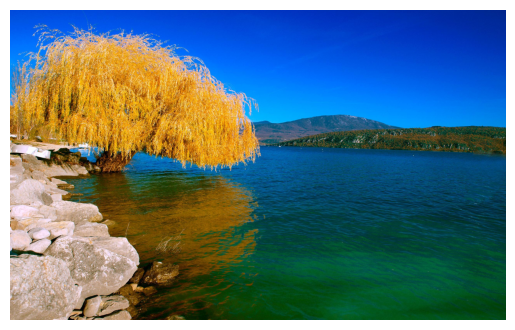


Model Output:
 USER:  
What is happening in this image?
ASSISTANT: In the image, there is a tree with yellow leaves reflected in the water of a lake. The tree and its reflection create a serene and picturesque scene. The background features mountains that add to the beauty of the landscape. The combination of the tree, the water, and the mountains create a harmonious and captivating environment.

Chosen: A dog is running on the grass.
Rejected: A car is driving fast.
RLHF Reward Score: 0.0423

Processing Example 2


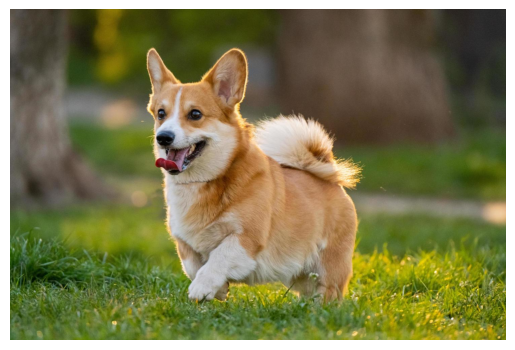


Model Output:
 USER:  
Describe the scene clearly.
ASSISTANT: The image features a brown and white corgi dog walking through a grassy field. The dog appears to be enjoying its time outdoors, possibly near a tree in the field. It looks like the dog is happily playing with its tail, creating a joyful scene. The dog's playful demeanor adds a lively touch to the otherwise peaceful, natural setting

Chosen: The scene shows a dog enjoying outdoor play.
Rejected: This is a picture of a building.
RLHF Reward Score: 0.0960


In [9]:
for i in range(len(dataset)):
    row = dataset[i]
    print("\n" + "=" * 70)
    print(f"Processing Example {i+1}")
    print("=" * 70)

    img = show_image(row["image"])
    output = generate_output(row["image"], row["prompt"])

    print("\nModel Output:\n", output)

    reward = reward_function(output, row["chosen"], row["rejected"])

    print("\nChosen:", row["chosen"])
    print("Rejected:", row["rejected"])
    print(f"RLHF Reward Score: {reward:.4f}")